# This notebook can be used to understand workflow of GAN to generate MNIST digit images

1. Theory: https://www.youtube.com/watch?v=5WoItGTWV54
1. Reference: https://github.com/eriklindernoren/PyTorch-GAN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
from torchvision.utils import save_image
from tqdm import tqdm
import shutil

In [3]:
from mnist_gan import get_root_path

In [4]:
PROJECT_PATH = get_root_path()
DATA_PATH = os.path.join(get_root_path(), "data")
RESULT_PATH = os.path.join(get_root_path(), "images")

try: 
    
    os.makedirs(DATA_PATH, exist_ok=True)
except Exception as e:
    print(e)

try:
    shutil.rmtree(RESULT_PATH)
    os.makedirs(RESULT_PATH, exist_ok=True)
except Exception as e:
    print(e)

BATCH_SIZE = 64
NUM_EPOCHS = 100
LATENT_FEATURES = 100

_OUT_FEATURES = 1
MNIST_SHAPE = (28, 28)
_mnist_features = np.prod(MNIST_SHAPE)

GEN_LR = 2e-4
DIS_LR = 1e-4
SAMPLE_INTERVAL = 400 # sample generated images after batches
device = "cuda" if torch.cuda.is_available() else "cpu"

<font color="blue">Note: it is important to scale image pixel values between -1. to 1.

In [5]:
# mean, std = (0.1307,), (0.3081,)
transform = transforms.Compose([
    transforms.ToTensor(), # convert pixel values range to [0.,1.]
    transforms.Lambda(lambda x: x*2 - 1.), # convert pixel values range to [-1., 1.]
#     transforms.Normalize(mean=mean, std=std),
    transforms.Lambda(lambda x: x.flatten())
])

train_dataset = datasets.MNIST(
    root=os.path.join(DATA_PATH, "mnist_data"), train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(
    root=os.path.join(DATA_PATH, "mnist_data"), train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

num_batches = len(train_loader)

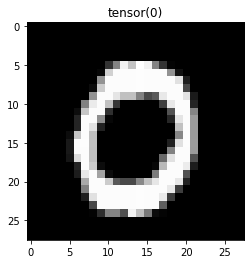

In [6]:
imgs, labels = next(iter(train_loader))
i = np.random.choice(len(imgs))

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(imgs[i].view(MNIST_SHAPE), cmap="gray")
ax.set_title(labels[i])
plt.show()

## Generator and Discriminator architecture

In [7]:
class Generator(nn.Module):
    def __init__(
        self, 
        in_features: int,
        out_features: int,
        negative_slope: float=.2):
        super().__init__()       
        self.fc1 = nn.Linear(in_features=in_features, out_features=256)
        self.fc2 = nn.Linear(
            in_features=self.fc1.out_features, out_features=self.fc1.out_features*2)
        self.fc3 = nn.Linear(
            in_features=self.fc2.out_features, out_features=self.fc2.out_features*2)
        self.fc4 = nn.Linear(
            in_features=self.fc3.out_features, out_features=out_features)
        self.negative_slope = negative_slope
    
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), negative_slope=self.negative_slope)
        x = F.leaky_relu(self.fc2(x), negative_slope=self.negative_slope)
        x = F.leaky_relu(self.fc3(x), negative_slope=self.negative_slope)
        return torch.tanh(self.fc4(x)) # tanh will bring values between -1. to 1.
            
    
class Discriminator(nn.Module):
    def __init__(
        self, 
        in_features: int,
        out_features: int, 
        negative_slope: float=.2,
        dropout: float=.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=1024)
        self.fc2 = nn.Linear(in_features=self.fc1.out_features, out_features=self.fc1.out_features//2)
        self.fc3 = nn.Linear(in_features=self.fc2.out_features, out_features=self.fc2.out_features//2)
        self.fc4 = nn.Linear(in_features=self.fc3.out_features, out_features=1)
        self.negative_slope = negative_slope
        self.dropout = dropout
    
    def forward(self, x):
        x = F.dropout(
            F.leaky_relu(self.fc1(x), negative_slope=self.negative_slope),
            p=self.dropout)
        x = F.dropout(
            F.leaky_relu(self.fc2(x), negative_slope=self.negative_slope),
            p=self.dropout)
        x = F.dropout(
            F.leaky_relu(self.fc3(x), negative_slope=self.negative_slope),
            p=self.dropout)
        return self.fc4(x)

In [8]:
G = Generator(in_features=LATENT_FEATURES, out_features=_mnist_features).to(device)
D = Discriminator(in_features=_mnist_features, out_features=_OUT_FEATURES).to(device)

In [9]:
G.eval()
assert G(torch.randn(size=(BATCH_SIZE, LATENT_FEATURES), device=device)).shape == imgs.flatten(start_dim=1).shape

In [10]:
G.eval()
D.eval()
assert D(G(torch.randn(size=(BATCH_SIZE, LATENT_FEATURES), device=device))).shape == (BATCH_SIZE, _OUT_FEATURES)

In [11]:
G_optim = Adam(G.parameters(), lr=GEN_LR)
D_optim = Adam(D.parameters(), lr=DIS_LR)

In [12]:
def D_loss(
    y_hat_real: torch.Tensor,
    y_hat_fake: torch.Tensor,
    epsilon: float=1e-9) -> float:
    """
    Return loss for Discrimantor.
    
    Parameters
    ----------
    y_hat_real: torch.Tensor of shape (n, 1)
        float values in unconstrained space
    
    y_hat_fake: torch.Tensor of shape (n, 1)
        float values in unconstrained space
        
    epsilon: float, default=1e-9
        Adjustment to prevent nan and inf issues.

    Return
    ------
    loss: float
    """
    y_hat_real = torch.sigmoid(y_hat_real)
    y_hat_fake = torch.sigmoid(y_hat_fake)
    
    return - torch.mean(
        torch.log(y_hat_real + epsilon) 
        + torch.log(1 - y_hat_fake + epsilon)
    )

In [13]:
def G_loss(
    y_hat_fake: torch.Tensor, 
    epsilon: float=1e-9) -> float:
    """
    Return loss for Generator.
    
    Parameters
    ----------
    y_hat_fake: torch.Tensor of shape (n, 1)
        float values in unconstrained space
        
    epsilon: float, default=1e-9
        Adjustment to prevent nan and inf issues.

    Return
    ------
    loss: float
    """
    y_hat_fake = torch.sigmoid(y_hat_fake)
    return - torch.mean(torch.log(y_hat_fake + epsilon))

Comparing manual designed loss with built-in torch binary cross entropy loss 

In [14]:
X_real, _ = next(iter(train_loader))
X_real = X_real.flatten(start_dim=1).to(device)

with torch.set_grad_enabled(False):
    D.eval()
    G.eval()
    
#     ====================== Discriminator ==========================
    Y_hat_real = D(X_real)
    real_bce_loss = nn.BCEWithLogitsLoss()(
        Y_hat_real, torch.ones((len(X_real), 1), device=device))
        
    Z = torch.randn(size=(len(X_real), LATENT_FEATURES), device=device)
    X_fake = G(Z)
    Y_hat_fake = D(X_fake.detach())
    fake_bce_loss = nn.BCEWithLogitsLoss()(
        Y_hat_fake, torch.zeros((len(X_real), 1), device=device))

    assert torch.allclose(real_bce_loss + fake_bce_loss, D_loss(y_hat_real=Y_hat_real, y_hat_fake=Y_hat_fake))    
#     ===================== Generator ==========================
    X_fake = G(Z)
    Y_hat_fake = D(X_fake)
    g_bce_loss = nn.BCEWithLogitsLoss()(
        Y_hat_fake, torch.ones((len(X_real), 1), device=device))
    assert torch.allclose(g_bce_loss, G_loss(y_hat_fake=Y_hat_fake))

In [15]:
losses = {"D":[], "G":[]}

In [16]:
with torch.set_grad_enabled(True):
    D.train()
    G.train()    
    t = tqdm(range(NUM_EPOCHS), leave=False)
    for epoch in t:
        for batch_no, (X_real, _) in enumerate(train_loader):
            
            
            # ================= Train Discriminator =======================
            Y_real =  torch.ones((len(X_real), 1), device=device)
            Y_hat_real = D(X_real.to(device))
            
            Y_fake =  torch.zeros((len(X_real), 1), device=device)
            Z = torch.randn(size=(len(X_real), LATENT_FEATURES), device=device)
            X_fake = G(Z)
            Y_hat_fake = D(X_fake.detach())

            D_optim.zero_grad()
            d_loss = D_loss(y_hat_real=Y_hat_real, y_hat_fake=Y_hat_fake)
            d_loss.backward()
            D_optim.step()
            losses["D"].append(d_loss.item())

            # ==================== Train Generator =========================
            X_fake = G(Z)
            Y_hat_fake = D(X_fake)

            G_optim.zero_grad()
            g_loss = G_loss(Y_hat_fake)
            g_loss.backward()
            G_optim.step()
            losses["G"].append(g_loss.item())

            t.set_description(f"E: {epoch}, B: {batch_no}, D: {losses['D'][-1]:.3f}, G: {losses['G'][-1]:.3f}")
            
            num_batches_processed = epoch * num_batches + batch_no
            if num_batches_processed % SAMPLE_INTERVAL == 0:
                save_image(X_fake.data[:25].view(25, 1, *(MNIST_SHAPE)), f"{RESULT_PATH}/{num_batches_processed}.png", nrow=5, normalize=True)

## Key Lessons:

1. Leaky ReLU better than ReLU activation
1. Tanh for Generator
1. If discriminator learns better than generator then generator would not be able to produce realistic fake image.